In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

/tmp/ipykernel_141087/2115483293.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-22 07:49:53.850942: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 07:49:53.889242: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 07:4

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


## Example Pinball loss / Quantile loss

In [3]:
tau=0.1
y_hat=3
y=np.linspace(y_hat-10,y_hat+10,100)

# Calculate loss
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat
loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [4]:
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat

loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [5]:
tau=0.1
y_hat=3
y=np.linspace(-100,100,1000)
y_ints=np.unique(np.ceil(y))
y_ticks=y_ints[np.nonzero((y_ints%2)==0)]

def plot_function(tau,y_tau):
    
    loss=(1-tau)*(np.abs(y_tau-y))
    y_larger=y>y_tau
    loss[y_larger]=tau*(np.abs(y_tau-y[y_larger]))

    plt.plot(y,loss)
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.vlines(y_tau,-10,20,'r','--')
    plt.grid()
    plt.xticks(y_ticks)
    plt.xlim([-10,10])
    plt.ylim([-1,10])
    plt.legend([r'$\mathcal{L}(y_{\tau},y)$',r'$y_{\tau}$'])
    plt.xlabel("y")
    plt.ylabel(r'$\mathcal{L}$')
    plt.title(r'Example of the Quantile loss / Pinball loss function')
    plt.show()
    
interact(plot_function, tau = widgets.FloatSlider(value=0.1,
                                               min=0.0,
                                               max=1.0,
                                               step=0.01),
                        y_tau=widgets.FloatSlider(value=0,
                                               min=-5,
                                               max=5,
                                               step=0.1))

interactive(children=(FloatSlider(value=0.1, description='tau', max=1.0, step=0.01), FloatSlider(value=0.0, de…

<function __main__.plot_function(tau, y_tau)>

## Plot for report

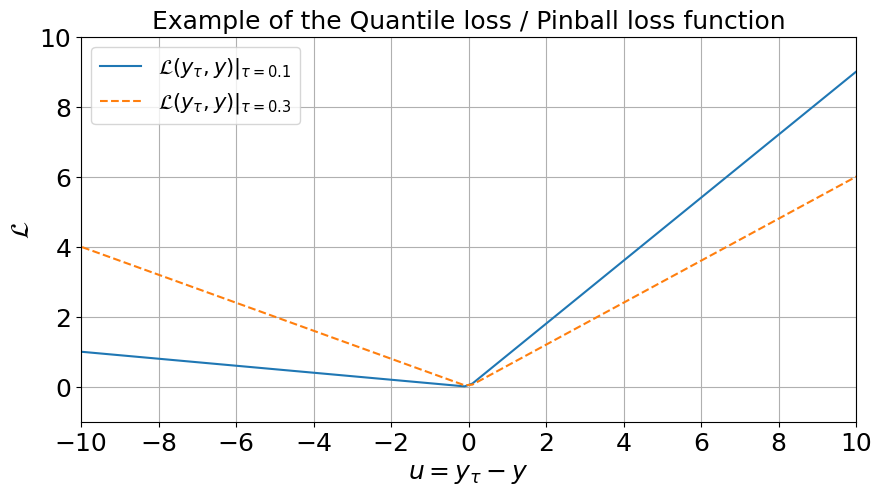

In [6]:
tau=0.1
u=np.linspace(-100,100,1000)
u_ints=np.unique(np.ceil(u))
u_ticks=u_ints[np.nonzero((u_ints%2)==0)]    

loss=(1-tau)*(np.abs(u))
y_larger=u<0
loss[y_larger]=tau*(np.abs(u[y_larger]))

tau_2=0.4
loss_2=(1-tau_2)*(np.abs(u))
loss_2[y_larger]=tau_2*(np.abs(u[y_larger]))

fontsize=18

plt.plot(y,loss)
plt.plot(y,loss_2,'--')
plt.rcParams["figure.figsize"] = [10, 5]
plt.grid()
plt.xticks(y_ticks,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlim([-10,10])
plt.ylim([-1,10])
plt.legend([r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.1}$',r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.3}$'],fontsize=fontsize-3)
plt.xlabel(r"$u=y_{\tau}-y$",fontsize=fontsize)
plt.ylabel(r'$\mathcal{L}$',fontsize=fontsize)
plt.title(r'Example of the Quantile loss / Pinball loss function',fontsize=fontsize)
plt.show()

## Example Quantile Regression Neural Networks (QRNN)

In [13]:
def draw_sample_sin(n_samps, sigma):
    x=np.random.uniform(low=0,high=2*np.pi,size=n_samps)
    noise=np.random.normal(loc=0,scale=sigma,size=n_samps)
    y=np.sin(x)+noise
    return x,y

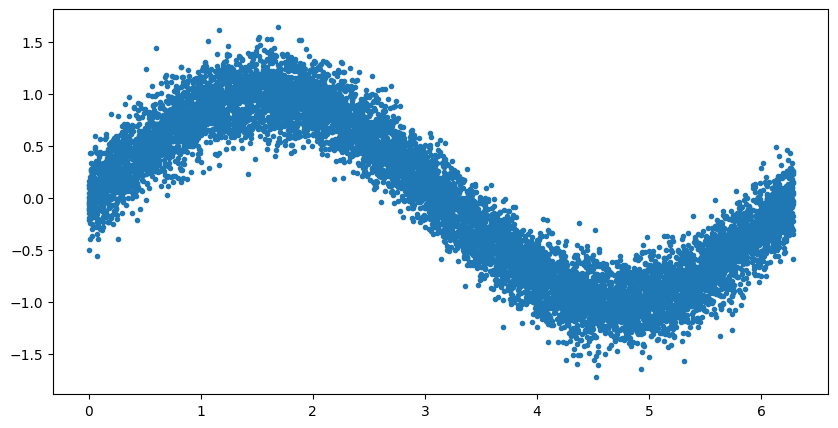

In [18]:
x,y = draw_sample_sin(10000,0.2)
plt.plot(x,y,'.')